In [71]:
%reload_ext autoreload
%autoreload 2

from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Spice.Parser import SpiceParser
from PySpice.Probe.WaveForm import WaveForm
from PySpice.Unit import *
import PySpice
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ltspice
import os
from helpers import *
from spice_net import *
import pickle

# ngspice
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-subprocess' 

# Xyce
# import PySpice.Spice.Xyce.Server
# PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'xyce-serial'
# PySpice.Spice.Xyce.Server.XyceServer.XYCE_COMMAND = '/Users/lancemathias/Projects/Xyce_build/src/Xyce'

# setup logging: logging silences Xyce complaints and makes Xyce simulations run ~10% faster
# negiligible speedup for ngspice
# from PySpice.Logging import Logging
# logger = Logging.setup_logging(logging_level='ERROR')

In [72]:
np.random.seed(0)

grid_graph = nx.grid_graph([4, 4], periodic=True)

for e in grid_graph.edges:
    # grid_graph[e[0]][e[1]]['weight'] = np.random.uniform(0, 1)    # random init
    grid_graph[e[0]][e[1]]['weight'] = 5                            # init to max value

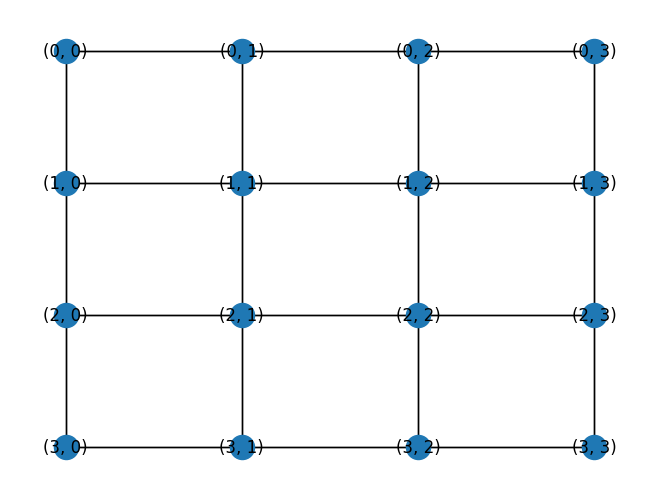

In [73]:
nx.draw(grid_graph, pos={(x,y):(y,-x) for x,y in grid_graph.nodes()}, with_labels=True)

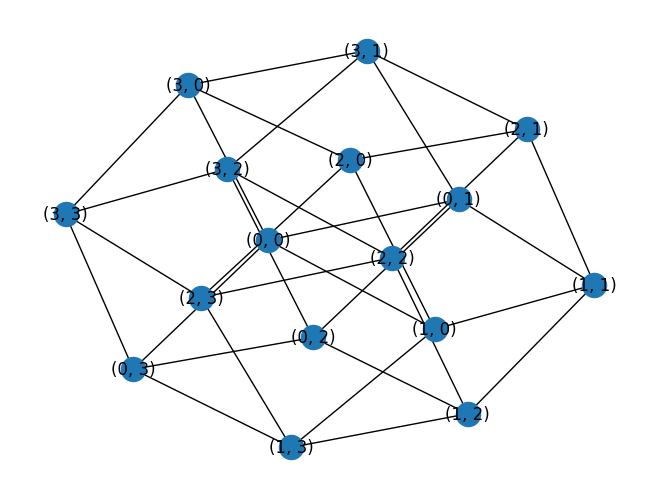

In [74]:
nx.draw(grid_graph, pos=nx.spring_layout(grid_graph, weight=None), with_labels=True)

In [79]:
n_pts = 20
np.random.seed(0)

dset = {}
dset['inputs'] = np.sort(np.random.uniform(0, 1, (n_pts, 1)), axis=0)
dset['outputs'] = dset['inputs']**2

In [68]:
transistor = GroundReferenceNetwork('groundref_test', con_graph=grid_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)

In [69]:
%timeit transistor.solve(dset['inputs'], dset['outputs'])

18.1 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
eta = 0.1
gamma = 10*1/eta
epochs = 100

transistor, loss, updates, weights = train(transistor, dset['inputs'], dset['outputs'], epochs=epochs, gamma=gamma, eta=eta, log_steps=epochs//10)

Epoch 1: 0.028712144978262372
Epoch 11: 0.024672102225274165
Epoch 21: 0.021149266777964013
Epoch 31: 0.021474946213783576
Epoch 41: 0.020255270166801204
Epoch 51: 0.020008992350926312
Epoch 61: 0.019591745831517772
Epoch 71: 0.019207796506342713
Epoch 81: 0.01901713680504902
Epoch 91: 0.018605518613817592


In [40]:
eta = 0.1
gamma = 10*1/eta
epochs = 100

transistor, loss, updates, weights = train(transistor, dset['inputs'], dset['outputs'], epochs=epochs, gamma=gamma, eta=eta, log_steps=epochs//10)

Epoch 1: 0.028712144978262372
Epoch 11: 0.024672102225274165
Epoch 21: 0.021149266777964013
Epoch 31: 0.021474946213783576
Epoch 41: 0.020255270166801204
Epoch 51: 0.020008992350926312
Epoch 61: 0.019591745831517772
Epoch 71: 0.019207796506342713
Epoch 81: 0.01901713680504902
Epoch 91: 0.018605518613817592


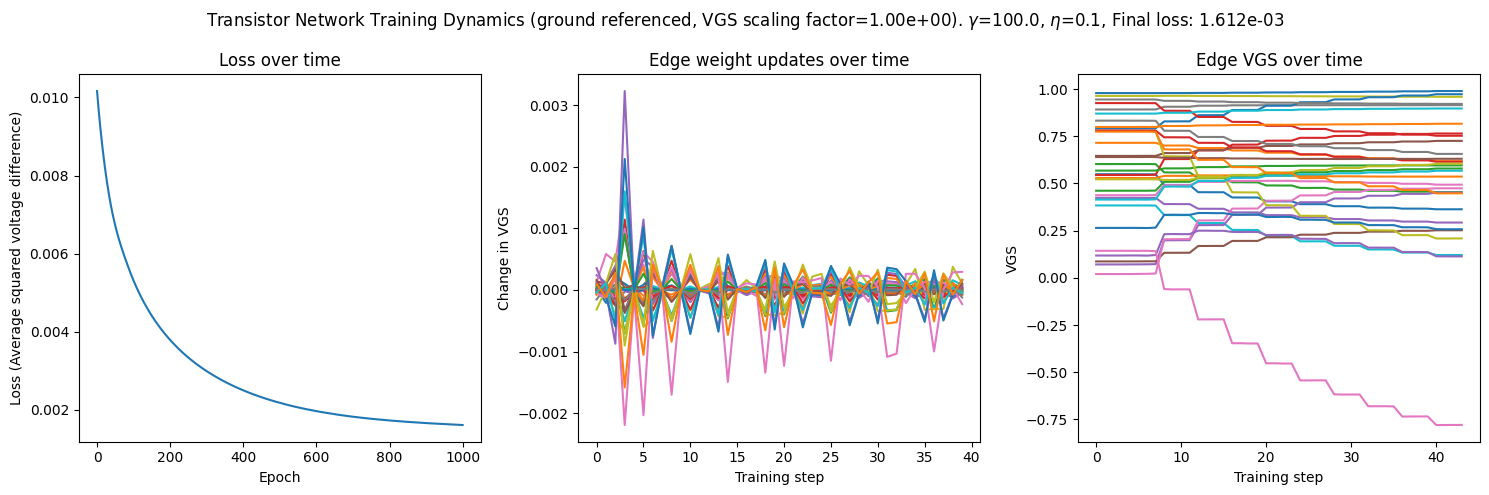

In [143]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle(f'Transistor Network Training Dynamics (ground referenced, VGS scaling factor={transistor.edges[0].alpha:.2e}). $\gamma$={gamma}, $\eta$={eta}, Final loss: {loss[-1]:.3e}')

plt.subplot(1, 3, 1)
plt.plot(loss)
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss (Average squared voltage difference)')

plt.subplot(1, 3, 2)
plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.title('Edge weight updates over time')
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.xlabel('Training step')
plt.ylabel('Change in VGS')

plt.subplot(1, 3, 3)
plt.plot(weights.reshape(-1, weights.shape[-1]))
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.title('Edge VGS over time')
plt.xlabel('Training step')
plt.ylabel('VGS')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Vout')

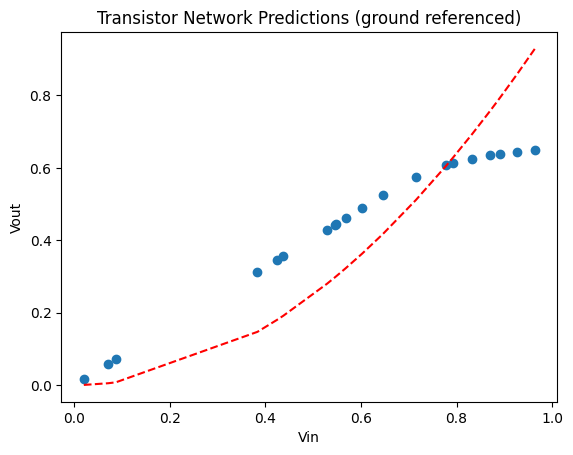

In [27]:
plt.plot(dset['inputs'], dset['outputs'], 'r--', label='Target')
plt.scatter(dset['inputs'], transistor.predict(dset['inputs']), label='Predictions')
plt.title('Transistor Network Predictions (ground referenced)')
plt.xlabel('Vin')
plt.ylabel('Vout')

In [28]:
transistor = TransistorNetwork('sourceref_test', con_graph=grid_graph, node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)

In [29]:
eta = 0.1
gamma = 10*1/eta
transistor, loss, updates, weights = train(transistor, dset['inputs'], dset['outputs'], epochs=100, gamma=gamma, eta=eta, log_steps=list(range(0, 100, 10)))

Epoch 1: 0.03447945193771055
Epoch 11: 0.022836280606760413
Epoch 21: 0.021977283627685768
Epoch 31: 0.02095441909449245
Epoch 41: 0.020031034630399965
Epoch 51: 0.01996147888340135
Epoch 61: 0.01918222515070377
Epoch 71: 0.018978142517936784
Epoch 81: 0.018883337731235274
Epoch 91: 0.018731543932260432


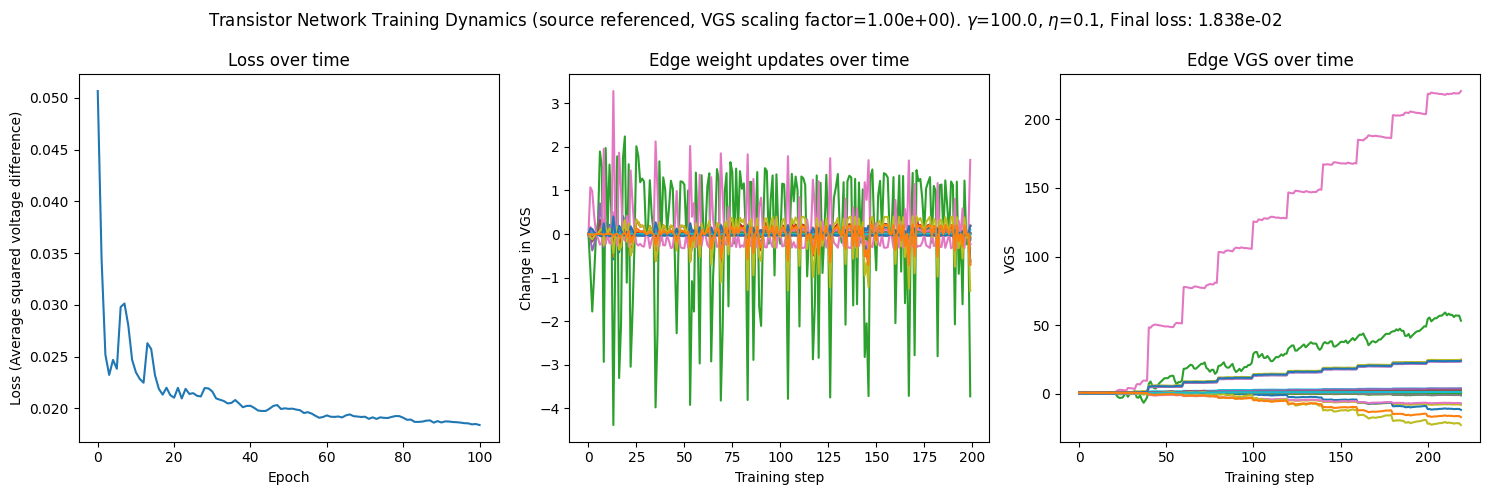

In [30]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle(f'Transistor Network Training Dynamics (source referenced, VGS scaling factor={transistor.edges[0].alpha:.2e}). $\gamma$={gamma}, $\eta$={eta}, Final loss: {loss[-1]:.3e}')

plt.subplot(1, 3, 1)
plt.plot(loss)
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss (Average squared voltage difference)')

plt.subplot(1, 3, 2)
plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.title('Edge weight updates over time')
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.xlabel('Training step')
plt.ylabel('Change in VGS')

plt.subplot(1, 3, 3)
plt.plot(weights.reshape(-1, weights.shape[-1]))
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.title('Edge VGS over time')
plt.xlabel('Training step')
plt.ylabel('VGS')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Vout')

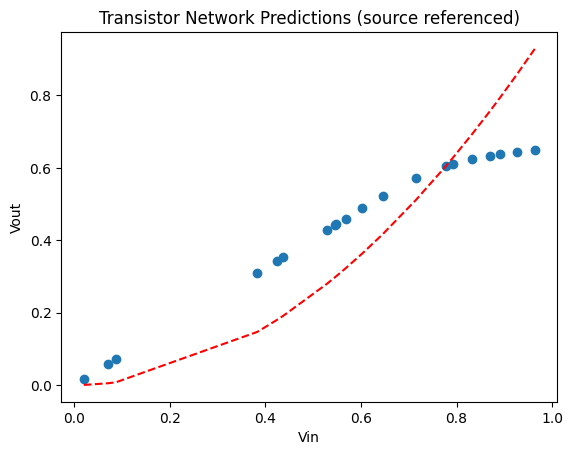

In [31]:
plt.plot(dset['inputs'], dset['outputs'], 'r--', label='Target')
plt.scatter(dset['inputs'], transistor.predict(dset['inputs']), label='Predictions')
plt.title('Transistor Network Predictions (source referenced)')
plt.xlabel('Vin')
plt.ylabel('Vout')

## Replicate Figure 3 (XOR Task)

In [96]:
I_pos = 0.33
I_neg = 0.11
I_0 = 0.45
L_0 = -0.087

In [97]:
np.random.seed(0)

grid_graph = nx.grid_graph([4, 4], periodic=True)
grid_graph.add_node((-1, -1))

for e in grid_graph.edges:
    grid_graph[e[0]][e[1]]['weight'] = np.random.uniform(0, 1)    # random init
    # grid_graph[e[0]][e[1]]['weight'] = 5                           # init to max value

pos = {i:(y,-x) for i,(x,y) in enumerate(grid_graph.nodes())}

In [98]:
# input orderings: I_neg, I_pos, I__2, I_1
# output orderings: O is represented using a single differential source
node_cfg = (np.array([[5, 16], [7, 16], [13, 16], [15, 16]]), np.array([[10, 0]]))
xor_groundref = GroundReferenceNetwork('xor_test (ground reference)', con_graph=grid_graph, node_cfg=node_cfg, epsilon=1e-16)

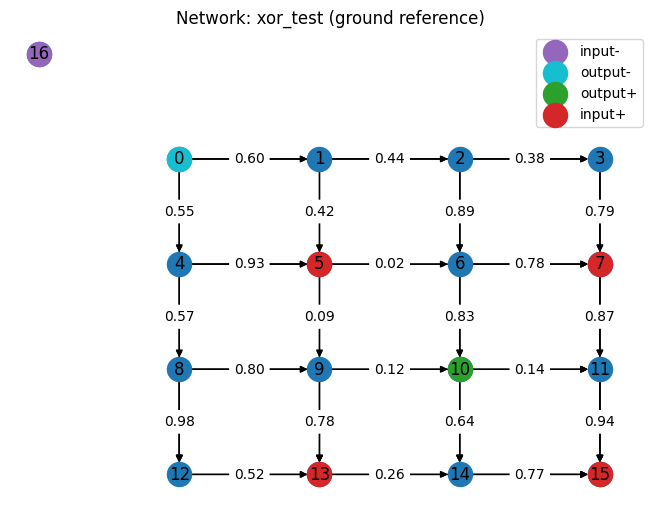

In [99]:
visualize(xor_groundref, pos)

In [100]:
train_inputs = []
train_outputs = []

for i1 in [0, 1]:
    for i2 in [0, 1]:
        train_inputs.append([I_neg, I_pos, I_0*i1, I_0*i2])
        train_outputs.append([L_0 * (i1 != i2)])
train_inputs = np.array(train_inputs)
train_outputs = np.array(train_outputs)

np.savez('xor_train_data.npz', inputs=train_inputs, outputs=train_outputs)

In [101]:
# initial conditions
paper_ic = np.array([[-0.03, -0.02], [-0.16, -0.2]])
# max_ic = xor_groundref.predict(train_inputs).reshape(2, 2,) / L_0
# U_0_5_ic = xor_groundref.predict(train_inputs).reshape(2, 2,) / L_0
U_0_1_ic = xor_groundref.predict(train_inputs).reshape(2, 2,) / L_0

In [105]:
# train the network
eta = 0.5
gamma = 0.1*1/eta
epochs = 1000

intermediate_preds = []

# for _ in range(10):
#     xor_net, loss, updates, weights = train(xor_net, train_inputs, train_outputs, epochs=epochs, gamma=gamma, eta=eta, log_steps=list(range(0, epochs, epochs//10)))
#     intermediate_preds.append(xor_net.predict(train_inputs))

# train the network
eta = 0.5
# gamma = 1/(100*22*1e-6*0.33) # update rule according to fig. 4 of the paper # wayyyy too high
gamma = 0.1 * 1/eta
epochs = 1000

intermediate_preds = []
total_loss = []
total_updates = []
total_weights = []

for i in range(10):
    xor_groundref, loss, updates, weights = train(xor_groundref, train_inputs, train_outputs, epochs=epochs, gamma=gamma, eta=eta, log_steps=epochs//10)
    intermediate_preds.append(xor_groundref.predict(train_inputs))

    total_loss.append(loss)
    total_updates.append(updates)
    total_weights.append(weights)

    with open (f'checkpoints/xor_groundref_{i}.pkl', 'wb') as f:
        pickle.dump(dict(
            total_loss=total_loss,
            total_updates=total_updates,
            total_weights=total_weights,
            intermediate_preds=intermediate_preds,
            eta=eta,
            gamma=gamma,
            epochs=epochs
        ), f)

Epoch 1: 0.010049376753272573
Epoch 101: 0.0052847883382746656


KeyboardInterrupt: 

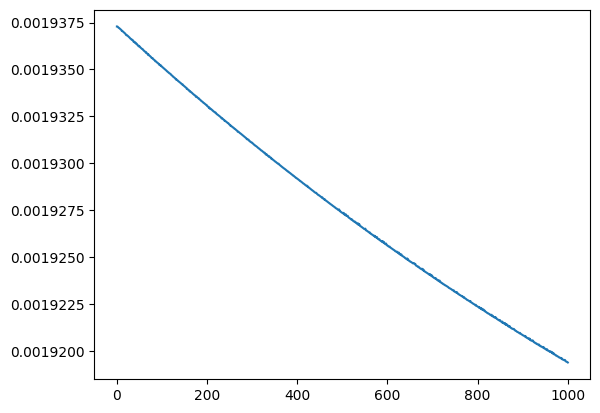

In [410]:
plt.plot(loss)

In [387]:
xor_net.predict(train_inputs) / L_0

array([[0.44139307],
       [0.48250619],
       [0.40539794],
       [0.44515464]])

In [411]:
xor_trained = xor_net

TypeError: 'Axes' object is not subscriptable

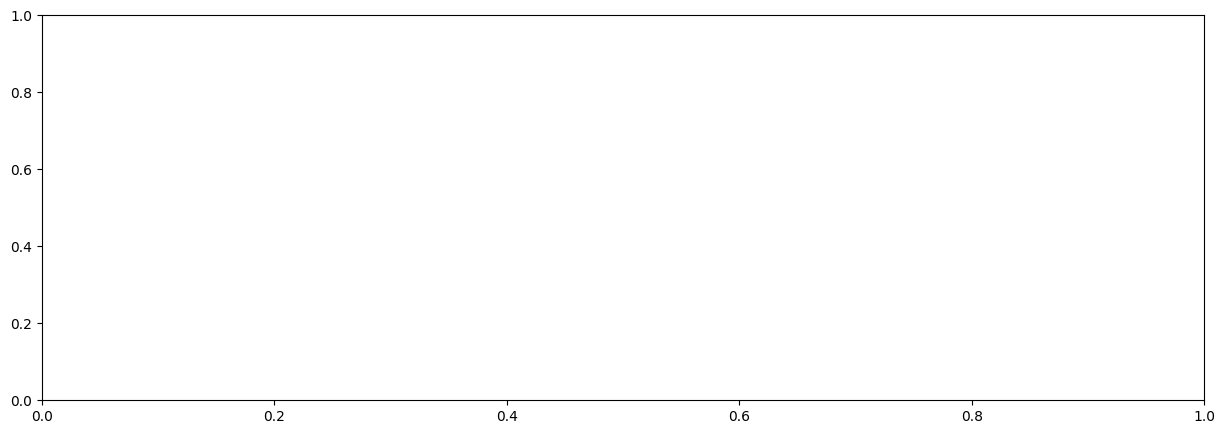

In [426]:
n_plots = len(intermediate_preds[::2])
fig, axs = plt.subplots(1, n_plots+1, figsize=(15, 5))
axs[0].imshow(train_outputs.reshape(2, 2) / L_0)
axs[0].set_title('Target')
for i in range(n_plots):
    im = axs[i+1].imshow(intermediate_preds[::2][i].reshape(2, 2) / L_0, vmin=0, vmax=1)
    axs[i+1].set_title(f'{2*epochs*i} steps')
fig.colorbar(im, ax=axs.ravel().tolist(), location='bottom')
fig.suptitle('XOR Network Training Dynamics (ground referenced)')

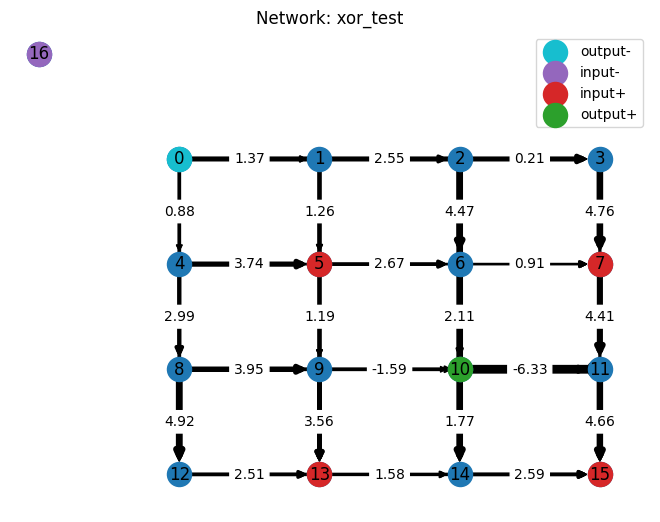

In [253]:
visualize(xor_net, pos)

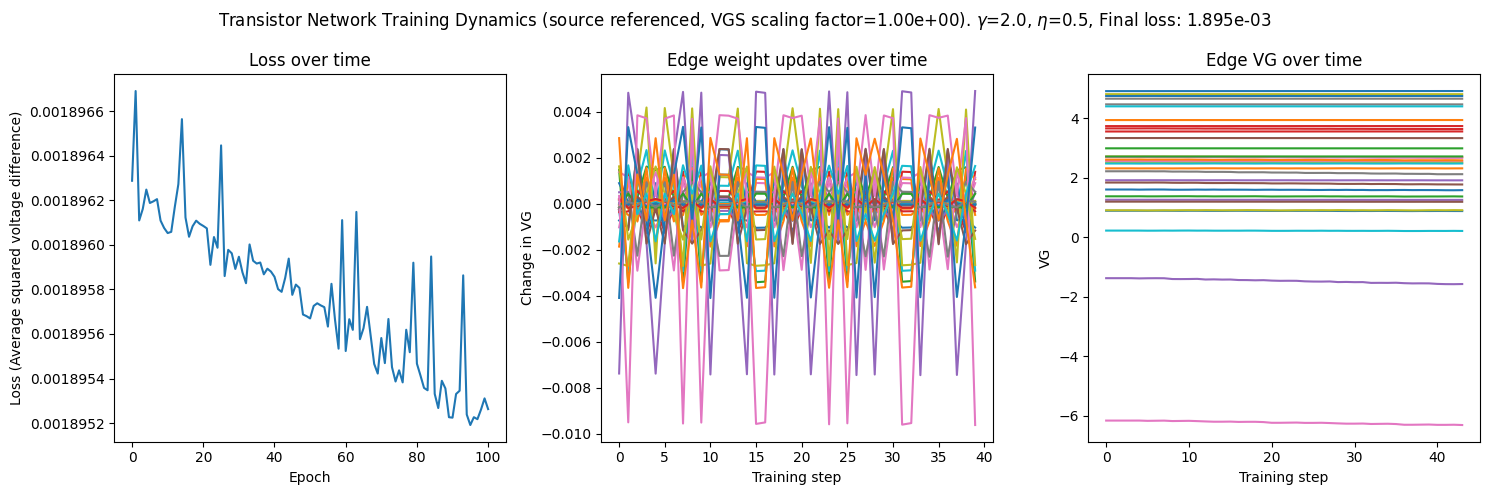

In [254]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle(f'Transistor Network Training Dynamics (ground referenced, VG scaling factor={transistor.edges[0].alpha:.2e}). $\gamma$={gamma}, $\eta$={eta}, Final loss: {loss[-1]:.3e}')

plt.subplot(1, 3, 1)
plt.plot(loss)
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss (Average squared voltage difference)')

plt.subplot(1, 3, 2)
plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.title('Edge weight updates over time')
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.xlabel('Training step')
plt.ylabel('Change in VG')

plt.subplot(1, 3, 3)
plt.plot(weights.reshape(-1, weights.shape[-1]))
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.title('Edge VG over time')
plt.xlabel('Training step')
plt.ylabel('VG')

plt.tight_layout()
plt.show()

## Retry with source reference

In [427]:
np.random.seed(0)

grid_graph = nx.grid_graph([4, 4], periodic=True)
grid_graph.add_node((-1, -1))

for e in grid_graph.edges:
    grid_graph[e[0]][e[1]]['weight'] = np.random.uniform(0, 5)    # random init
    # grid_graph[e[0]][e[1]]['weight'] = 5                            # init to max value

pos = {i:(y,-x) for i,(x,y) in enumerate(grid_graph.nodes())}

In [428]:
# input orderings: I_neg, I_pos, I__2, I_1
# output orderings: O is represented using a single differential source
node_cfg = (np.array([[5, 16], [7, 16], [13, 16], [15, 16]]), np.array([[10, 0]]))
xor_net = TransistorNetwork('xor_test (source_reference)', con_graph=grid_graph, node_cfg=node_cfg, epsilon=1e-16)

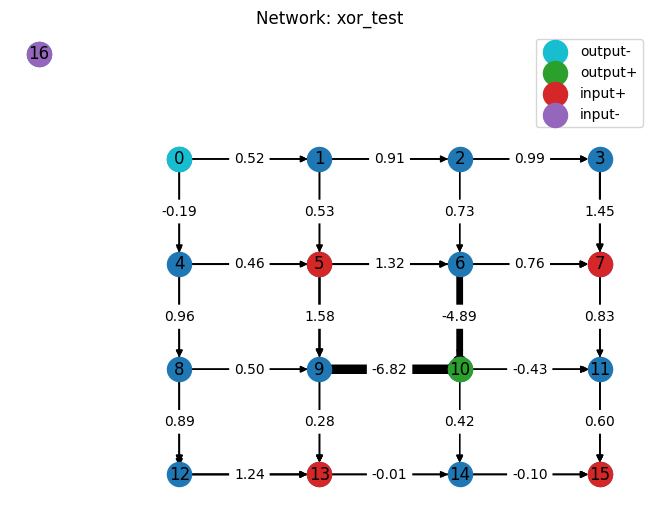

In [63]:
visualize(xor_net, pos)

In [26]:
# train the network
eta = 0.5
# gamma = 1/(100*22*1e-6*0.33) # update rule according to fig. 4 of the paper # wayyyy too high
gamma = 0.1 * 1/eta
epochs = 1000

intermediate_preds = []

for _ in range(30):
    xor_net, loss, updates, weights = train(xor_net, train_inputs, train_outputs, epochs=epochs, gamma=gamma, eta=eta, log_steps=list(range(0, epochs, epochs//10)))
    intermediate_preds.append(xor_net.predict(train_inputs))

Epoch 1: 0.003780891148241447
Epoch 101: 0.0034561198911067285
Epoch 201: 0.0031874043766103566
Epoch 301: 0.0029636716432606238
Epoch 401: 0.0027766449153400325
Epoch 501: 0.0026199389490842604
Epoch 601: 0.0024885047171858566
Epoch 701: 0.0023782012888615835
Epoch 801: 0.0022856747451112814
Epoch 901: 0.0022081203761024045
Epoch 1: 0.002143166204261877
Epoch 101: 0.0020888323000945452
Epoch 201: 0.0020433587515565994
Epoch 301: 0.0020053785377468812
Epoch 401: 0.001973694483622936
Epoch 501: 0.0019470835514365141
Epoch 601: 0.00192486923636934
Epoch 701: 0.0019062403990542758
Epoch 801: 0.001890555633031913
Epoch 901: 0.0018773100429593838
Epoch 1: 0.0018661062507766301
Epoch 101: 0.0018565039081351348
Epoch 201: 0.0018482793722496725
Epoch 301: 0.0018411546179468398
Epoch 401: 0.0018349519924443108
Epoch 501: 0.0018294606167075776
Epoch 601: 0.0018245657848737933
Epoch 701: 0.00182012621676467
Epoch 801: 0.0018161179131202508
Epoch 901: 0.0018123994662243054
Epoch 1: 0.0018088642912

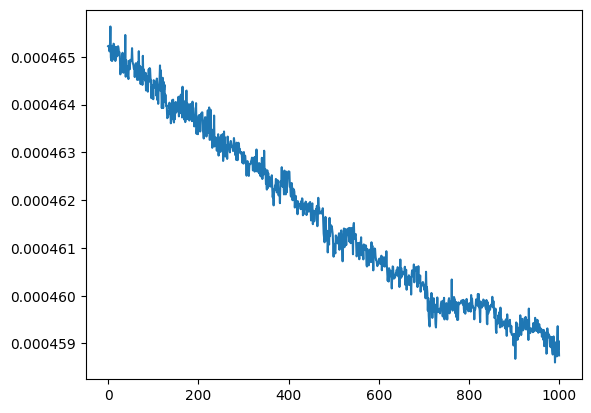

In [27]:
plt.plot(loss)

In [44]:
losses_long = """Epoch 1: 0.003780891148241447
Epoch 101: 0.0034561198911067285
Epoch 201: 0.0031874043766103566
Epoch 301: 0.0029636716432606238
Epoch 401: 0.0027766449153400325
Epoch 501: 0.0026199389490842604
Epoch 601: 0.0024885047171858566
Epoch 701: 0.0023782012888615835
Epoch 801: 0.0022856747451112814
Epoch 901: 0.0022081203761024045
Epoch 1: 0.002143166204261877
Epoch 101: 0.0020888323000945452
Epoch 201: 0.0020433587515565994
Epoch 301: 0.0020053785377468812
Epoch 401: 0.001973694483622936
Epoch 501: 0.0019470835514365141
Epoch 601: 0.00192486923636934
Epoch 701: 0.0019062403990542758
Epoch 801: 0.001890555633031913
Epoch 901: 0.0018773100429593838
Epoch 1: 0.0018661062507766301
Epoch 101: 0.0018565039081351348
Epoch 201: 0.0018482793722496725
Epoch 301: 0.0018411546179468398
Epoch 401: 0.0018349519924443108
Epoch 501: 0.0018294606167075776
Epoch 601: 0.0018245657848737933
Epoch 701: 0.00182012621676467
Epoch 801: 0.0018161179131202508
Epoch 901: 0.0018123994662243054
Epoch 1: 0.0018088642912101544
Epoch 101: 0.0018056071130662142
Epoch 201: 0.0018024595950629962
Epoch 301: 0.0017994675625879536
Epoch 401: 0.001796561080810376
Epoch 501: 0.0017938492859588563
Epoch 601: 0.0017910983011659863
Epoch 701: 0.0017882764817586344
Epoch 801: 0.0017855976206451636
Epoch 901: 0.0017828814292642123
Epoch 1: 0.0017802266770688914
Epoch 101: 0.0017775260109945097
Epoch 201: 0.0017748304648358727
Epoch 301: 0.0017721362904034657
Epoch 401: 0.001769455002180783
Epoch 501: 0.0017666849752940078
Epoch 601: 0.0017639345353209941
Epoch 701: 0.001761170152883409
Epoch 801: 0.0017583610674331463
Epoch 901: 0.0017554992017863229
Epoch 1: 0.0017526331567359029
Epoch 101: 0.0017497132536214094
Epoch 201: 0.0017467353150610412
Epoch 301: 0.0017437825742379956
Epoch 401: 0.0017407556224510981
Epoch 501: 0.0017376816518305986
Epoch 601: 0.0017345329391930185
Epoch 701: 0.0017314119980786134
Epoch 801: 0.0017281532846042747
Epoch 901: 0.0017249222624350505
Epoch 1: 0.0017215632327227215
Epoch 101: 0.0017181743115862592
Epoch 201: 0.0017147241897295601
Epoch 301: 0.0017112180589995323
Epoch 401: 0.0017075806008329218
Epoch 501: 0.0017038984946993198
Epoch 601: 0.0017001292739694616
Epoch 701: 0.0016962688941375731
Epoch 801: 0.0016923134188036504
Epoch 901: 0.001688252787517141
Epoch 1: 0.0016840793823234804
Epoch 101: 0.001679780864645627
Epoch 201: 0.0016753456763858358
Epoch 301: 0.001671257097692137
Epoch 401: 0.001668778906788724
Epoch 501: 0.0016679237536968705
Epoch 601: 0.0016686947931243558
Epoch 701: 0.001671101002360914
Epoch 801: 0.0016752269436786972
Epoch 901: 0.0016811274453872806
Epoch 1: 0.001688746131277061
Epoch 101: 0.0016979996218286066
Epoch 201: 0.0017088167617870572
Epoch 301: 0.0017195698171228592
Epoch 401: 0.0017287801309830157
Epoch 501: 0.0017364985403354135
Epoch 601: 0.0017425756712150513
Epoch 701: 0.001747071915378528
Epoch 801: 0.0017498995044895563
Epoch 901: 0.0017508871888641995
Epoch 1: 0.0017498480704395347
Epoch 101: 0.0017479969188226312
Epoch 201: 0.001746263146129373
Epoch 301: 0.0017447602138390965
Epoch 401: 0.0017433100685733918
Epoch 501: 0.0017420493218017227
Epoch 601: 0.0017407806998822966
Epoch 701: 0.0017396529217423304
Epoch 801: 0.001738486214712154
Epoch 901: 0.0017374267542688148
Epoch 1: 0.0017363739873477047
Epoch 101: 0.001735362953539352
Epoch 201: 0.0017343513139324715
Epoch 301: 0.0017333518253648673
Epoch 401: 0.0017324399262853593
Epoch 501: 0.0017313461848984452
Epoch 601: 0.0017303591140850369
Epoch 701: 0.0017293905053064064
Epoch 801: 0.0017283748581889166
Epoch 901: 0.0017273545679250422
Epoch 1: 0.001726313573795045
Epoch 101: 0.0017253060865550977
Epoch 201: 0.001724256931926094
Epoch 301: 0.001723160408110309
Epoch 401: 0.001721939223234972
Epoch 501: 0.0017207641271698123
Epoch 601: 0.001719554004961745
Epoch 701: 0.0017183084260064747
Epoch 801: 0.0017171513422884052
Epoch 901: 0.0017155535171559414
Epoch 1: 0.001714212461728956
Epoch 101: 0.0017127765897170613
Epoch 201: 0.0017112334602374258
Epoch 301: 0.0017095862261324807
Epoch 401: 0.0017077474816734623
Epoch 501: 0.001705996985881252
Epoch 601: 0.001703977974565124
Epoch 701: 0.0017017888008706925
Epoch 801: 0.001699523119871687
Epoch 901: 0.0016965268213260036
Epoch 1: 0.0016964099063535262
Epoch 101: 0.0017051229275026308
Epoch 201: 0.001721906141561005
Epoch 301: 0.0017492297142663719
Epoch 401: 0.0017879703378702765
Epoch 501: 0.001829620441748268
Epoch 601: 0.001867614693344841
Epoch 701: 0.0018997530513055454
Epoch 801: 0.0019220478140184736
Epoch 901: 0.001932330900233876
Epoch 1: 0.0019313662749229532
Epoch 101: 0.0019271238294769023
Epoch 201: 0.0019200548648521348
Epoch 301: 0.0019106243514974198
Epoch 401: 0.0019019244740851012
Epoch 501: 0.00188948674493759
Epoch 601: 0.001874713043608484
Epoch 701: 0.0018593671316972718
Epoch 801: 0.0018427439096412503
Epoch 901: 0.001825339573793094
Epoch 1: 0.0018070248656311973
Epoch 101: 0.001788088956858381
Epoch 201: 0.0017681536688534823
Epoch 301: 0.0017468060726583449
Epoch 401: 0.0017243941469172576
Epoch 501: 0.0017004128258899867
Epoch 601: 0.0016750070206735042
Epoch 701: 0.001647154427541775
Epoch 801: 0.001616766286934814
Epoch 901: 0.0015840137987047408
Epoch 1: 0.0015483166050731367
Epoch 101: 0.0015096700437291298
Epoch 201: 0.0014675193472259945
Epoch 301: 0.0014225113842210773
Epoch 401: 0.001373296227969029
Epoch 501: 0.0013225387698207192
Epoch 601: 0.0012718972671670987
Epoch 701: 0.0012212976740473805
Epoch 801: 0.0011736003377390155
Epoch 901: 0.0011286512573795242
Epoch 1: 0.0010884567226063604
Epoch 101: 0.0010743976535631963
Epoch 201: 0.0010681671043333142
Epoch 301: 0.001091999513936865
Epoch 401: 0.001148937145952524
Epoch 501: 0.0012023702618444028
Epoch 601: 0.0012477896905619624
Epoch 701: 0.0012824320170304502
Epoch 801: 0.0013099535909736164
Epoch 901: 0.001338168706126455
Epoch 1: 0.0013648550410591184
Epoch 101: 0.0013867575761172199
Epoch 201: 0.0014046833231628674
Epoch 301: 0.0014206951335617574
Epoch 401: 0.0014360557304724114
Epoch 501: 0.0014514950839939911
Epoch 601: 0.001467616868527763
Epoch 701: 0.001484874214349495
Epoch 801: 0.0015023615474527596
Epoch 901: 0.0015182542443686947
Epoch 1: 0.0015327345550180855
Epoch 101: 0.0015462568737769052
Epoch 201: 0.0015563934130411981
Epoch 301: 0.0015642061000572492
Epoch 401: 0.0015679561156168795
Epoch 501: 0.0015682456947688362
Epoch 601: 0.0015643603373590178
Epoch 701: 0.0015548619207752393
Epoch 801: 0.0015410694880909348
Epoch 901: 0.0015283053254866086
Epoch 1: 0.0015157902116352702
Epoch 101: 0.0015033122311201676
Epoch 201: 0.0014900600005274293
Epoch 301: 0.0014764605909720146
Epoch 401: 0.0014617753908520296
Epoch 501: 0.00144487412644137
Epoch 601: 0.0014256021215223527
Epoch 701: 0.001404272626271452
Epoch 801: 0.001380362655740528
Epoch 901: 0.0013537914969240078
Epoch 1: 0.0013241721032432295
Epoch 101: 0.0012593515336689752
Epoch 201: 0.0011199042060316892
Epoch 301: 0.0009364998242137835
Epoch 401: 0.0009712028493604588
Epoch 501: 0.0012397991123546386
Epoch 601: 0.001317652936270071
Epoch 701: 0.0012575954735976052
Epoch 801: 0.0011729806911046576
Epoch 901: 0.0010952707931769687
Epoch 1: 0.0010276207481696726
Epoch 101: 0.0009709547956130331
Epoch 201: 0.0009261220571536258
Epoch 301: 0.0008902513609517317
Epoch 401: 0.0008616509073844219
Epoch 501: 0.0008373412650379401
Epoch 601: 0.0008181497069548892
Epoch 701: 0.0008011645585260368
Epoch 801: 0.0007872243698589655
Epoch 901: 0.0007744400042541034
Epoch 1: 0.0007632178286125041
Epoch 101: 0.0007525545745165636
Epoch 201: 0.0007425444692261836
Epoch 301: 0.0007336255109679172
Epoch 401: 0.0007248237777185928
Epoch 501: 0.0007162875672078363
Epoch 601: 0.0007079100894096912
Epoch 701: 0.0007002370814945185
Epoch 801: 0.0006919998352713595
Epoch 901: 0.000684177944385912
Epoch 1: 0.0006757407929071783
Epoch 101: 0.0006668387870118432
Epoch 201: 0.0006582009958794583
Epoch 301: 0.0006498665725124364
Epoch 401: 0.0006409217024125222
Epoch 501: 0.0006329009901745762
Epoch 601: 0.0006235749119352601
Epoch 701: 0.0006160781835551088
Epoch 801: 0.00060823529401641
Epoch 901: 0.0006011224352242333
Epoch 1: 0.0005942011504573402
Epoch 101: 0.0005875567207329182
Epoch 201: 0.0005812896014051296
Epoch 301: 0.000575229757686727
Epoch 401: 0.0005695172846418224
Epoch 501: 0.000563851107398628
Epoch 601: 0.0005582967460744673
Epoch 701: 0.0005527812439643967
Epoch 801: 0.0005477509763862936
Epoch 901: 0.00054238862356086
Epoch 1: 0.0005380484989041279
Epoch 101: 0.0005334805598200726
Epoch 201: 0.0005286696490026786
Epoch 301: 0.0005246096446658872
Epoch 401: 0.0005207578399126689
Epoch 501: 0.0005168393463194868
Epoch 601: 0.0005130232378624854
Epoch 701: 0.0005094163991301534
Epoch 801: 0.0005063156839518228
Epoch 901: 0.0005030039851029199
Epoch 1: 0.0005002134458555786
Epoch 101: 0.0004971457797617331
Epoch 201: 0.0004942621522365587
Epoch 301: 0.0004917610306176605
Epoch 401: 0.0004892296878893448
Epoch 501: 0.00048712965823463703
Epoch 601: 0.0004847816816358128
Epoch 701: 0.00048275599594264023
Epoch 801: 0.000481117497907233
Epoch 901: 0.00047918182632940374
Epoch 1: 0.0004777167041974457
Epoch 101: 0.0004762033015127704
Epoch 201: 0.000475060602757879
Epoch 301: 0.0004728903723299334
Epoch 401: 0.0004716472566071049
Epoch 501: 0.0004705891136104274
Epoch 601: 0.00046955564726340577
Epoch 701: 0.00046799145728933624
Epoch 801: 0.00046722341039144284
Epoch 901: 0.00046565880047171396
Epoch 1: 0.0004652102585134706
Epoch 101: 0.0004645095234509782
Epoch 201: 0.0004637709183041391
Epoch 301: 0.0004630050130083447
Epoch 401: 0.0004625914518420503
Epoch 501: 0.0004610717916283518
Epoch 601: 0.0004607717299195496
Epoch 701: 0.0004601219793067564
Epoch 801: 0.0004598423811116744
Epoch 901: 0.00045914808445540755
"""

Text(0, 0.5, 'MSE')

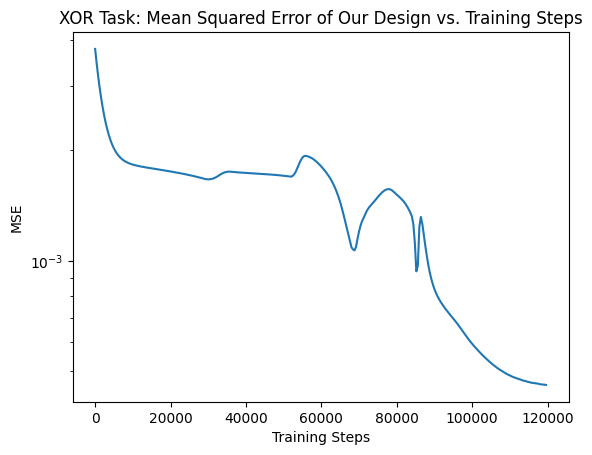

In [45]:
plt.title('XOR Task: Mean Squared Error of Our Design vs. Training Steps')
plt.plot(range(0, len(train_inputs)*100*len(list(filter(bool, losses_long.split('\n')))), 100*len(train_inputs)), list(map(lambda x: float(x.split(':')[-1]), filter(bool, losses_long.split('\n')))))
plt.xlabel('Training Steps')
plt.yscale('log')
plt.ylabel('MSE')

In [434]:
xor_net.predict(train_inputs) / L_0

array([[0.45965563],
       [0.54692188],
       [0.60680387],
       [0.52092787]])

In [35]:
n_plots

30

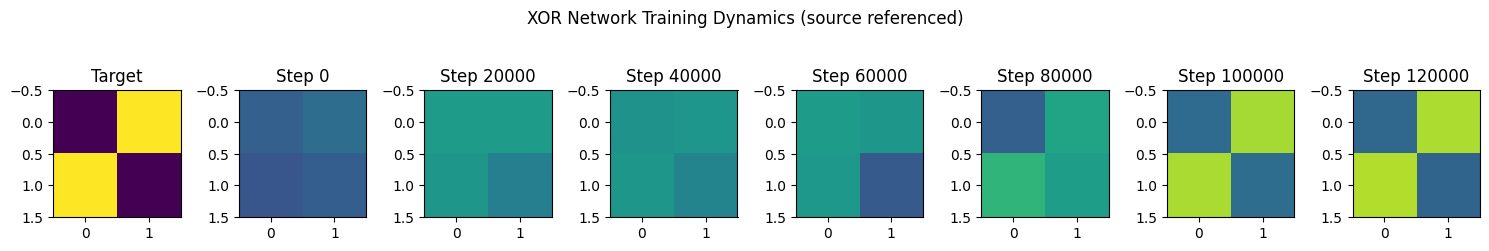

In [62]:
step = 5

n_plots = len(intermediate_preds)
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, n_plots//step+2, 1)
plt.imshow(train_outputs.reshape(2, 2) / L_0)
plt.title('Target')

for i in range(0, n_plots//step):
    plt.subplot(1, n_plots//step+2, i+2)
    plt.imshow(intermediate_preds[i*step].reshape(2, 2) / L_0, vmin=0, vmax=1)
    plt.title(f'Step {step*len(train_inputs)*epochs*i}')

i = n_plots//step
plt.subplot(1, n_plots//step+2, i+2)
plt.imshow(intermediate_preds[-1].reshape(2, 2) / L_0, vmin=0, vmax=1)
plt.title(f'Step {n_plots*len(train_inputs)*epochs}')

plt.tight_layout()
plt.suptitle('XOR Network Training Dynamics (source referenced)')
plt.savefig('xor_net_training_dynamics.png')

In [29]:
print(intermediate_preds)

[array([[-0.02677587],
       [-0.03119678],
       [-0.02318962],
       [-0.02592905]]), array([[-0.03893322],
       [-0.04232725],
       [-0.03507716],
       [-0.03546369]]), array([[-0.04381891],
       [-0.04575776],
       [-0.04075164],
       [-0.03841498]]), array([[-0.04583634],
       [-0.04692354],
       [-0.04341146],
       [-0.03890955]]), array([[-0.04690416],
       [-0.04751137],
       [-0.04489361],
       [-0.03844906]]), array([[-0.04772574],
       [-0.04795044],
       [-0.04605117],
       [-0.03750988]]), array([[-0.04859643],
       [-0.04836884],
       [-0.04729255],
       [-0.03613628]]), array([[-0.04950822],
       [-0.04832319],
       [-0.04862005],
       [-0.03653274]]), array([[-0.04805996],
       [-0.04634367],
       [-0.04787673],
       [-0.03880996]]), array([[-0.04565483],
       [-0.0458808 ],
       [-0.04685828],
       [-0.0394845 ]]), array([[-0.04448059],
       [-0.04563099],
       [-0.04593922],
       [-0.0391076 ]]), array([[-

In [30]:
np.savez('xor_net_training_dynamics.npz', intermediate_preds=intermediate_preds, train_inputs=train_inputs, train_outputs=train_outputs)

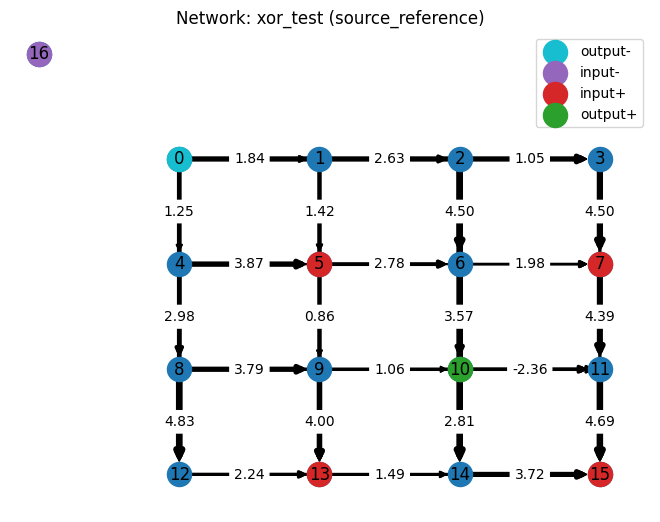

In [295]:
visualize(xor_net, pos)

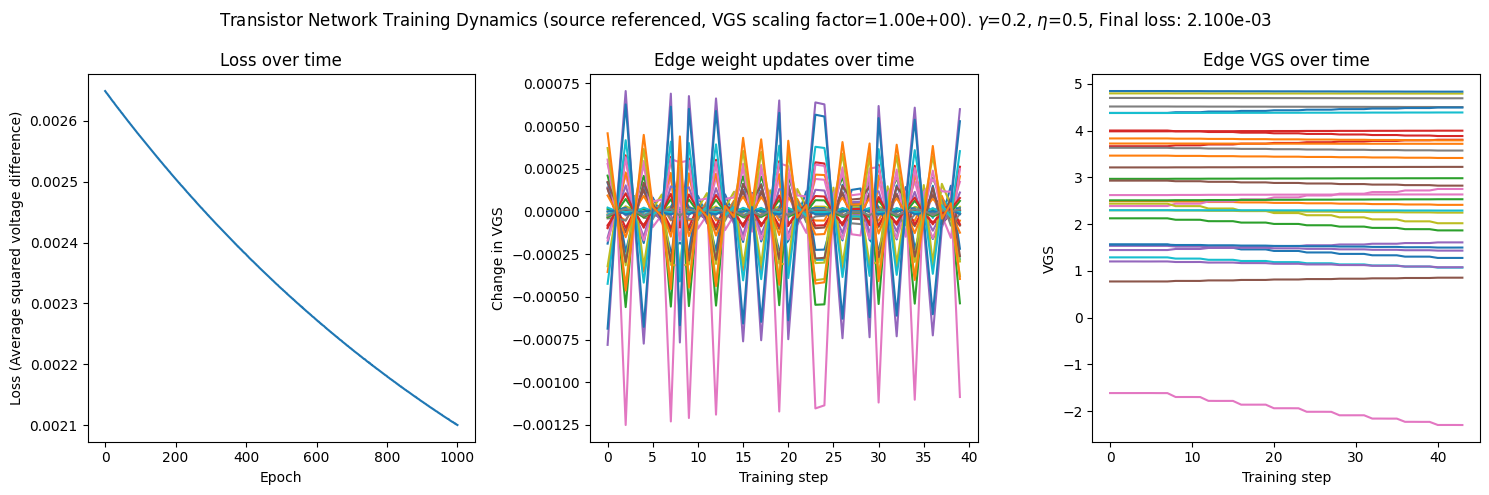

In [296]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle(f'Transistor Network Training Dynamics (source referenced, VGS scaling factor={transistor.edges[0].alpha:.2e}). $\gamma$={gamma}, $\eta$={eta}, Final loss: {loss[-1]:.3e}')

plt.subplot(1, 3, 1)
plt.plot(loss)
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss (Average squared voltage difference)')

plt.subplot(1, 3, 2)
plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.title('Edge weight updates over time')
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.xlabel('Training step')
plt.ylabel('Change in VGS')

plt.subplot(1, 3, 3)
plt.plot(weights.reshape(-1, weights.shape[-1]))
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.title('Edge VGS over time')
plt.xlabel('Training step')
plt.ylabel('VGS')

plt.tight_layout()
plt.show()

## Replicate figure 4: Nonlinear Regression

In [87]:
np.random.seed(0)

grid_graph = nx.grid_graph([4, 4], periodic=True)
grid_graph.add_node((-1, -1))

for e in grid_graph.edges:
    grid_graph[e[0]][e[1]]['weight'] = np.random.uniform(0, 5)    # random init
    # grid_graph[e[0]][e[1]]['weight'] = 5                            # init to max value

pos = {i:(y,-x) for i,(x,y) in enumerate(grid_graph.nodes())}

In [88]:
# input orderings: I_neg, I_pos, I_1
# output orderings: O is represented using a single output
node_cfg = (np.array([[8, 16], [2, 16], [15, 16]]), np.array([[10, 16]]))
nonlinear_net = TransistorNetwork('regression_test (source_reference)', con_graph=grid_graph, node_cfg=node_cfg, epsilon=1e-16)

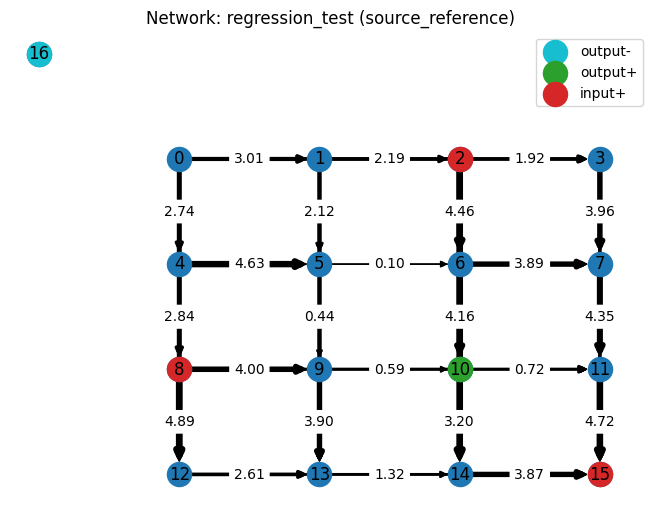

In [89]:
visualize(nonlinear_net, pos)

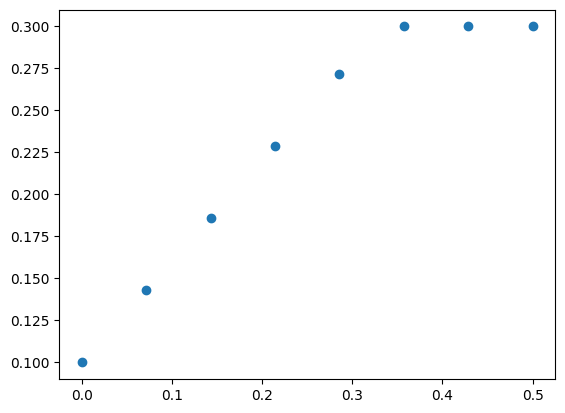

In [94]:
train_inputs = np.linspace(0, 0.5, 8)
train_inputs = np.vstack([np.zeros_like(train_inputs), 0.45*np.ones_like(train_inputs), train_inputs]).T
train_outputs = 0.6*np.array(train_inputs[:, -1]).reshape(8, 1)+0.1
train_outputs[-3:] = 0.3

plt.scatter(train_inputs[:,-1], train_outputs[:,0])

np.savez('nonlinear_regression_data.npz', inputs=train_inputs, outputs=train_outputs)

In [359]:
# train the network
eta = 1
# gamma = 1/(100*22*1e-6*0.33) # update rule according to fig. 4 of the paper # wayyyy too high
gamma = 0.1 * 1/eta
epochs = 100

intermediate_preds = []

for _ in range(3):
    nonlinear_net, loss, updates, weights = train(nonlinear_net, train_inputs, train_outputs, epochs=epochs, gamma=gamma, eta=eta, log_steps=list(range(0, epochs, epochs//10)))

Epoch 1: 0.0013098695554750424
Epoch 11: 0.0012547732318890306
Epoch 21: 0.0012050072311752798
Epoch 31: 0.0011600131912393517
Epoch 41: 0.0011192484766635634
Epoch 51: 0.0010822408224787318
Epoch 61: 0.0010486073784710575
Epoch 71: 0.0010179850079308891
Epoch 81: 0.0009900513551347862
Epoch 91: 0.0009645483038897875
Epoch 1: 0.0009412105613770694
Epoch 11: 0.0009198049844443344
Epoch 21: 0.0009001679659797534
Epoch 31: 0.0008821176202008804
Epoch 41: 0.0008654757124875612
Epoch 51: 0.0008501141117462959
Epoch 61: 0.0008359105923890961
Epoch 71: 0.0008227595545049627
Epoch 81: 0.0008105466410096221
Epoch 91: 0.0007991935527028057
Epoch 1: 0.0007886145806019088
Epoch 11: 0.0007787428895691042
Epoch 21: 0.0007695098541614972
Epoch 31: 0.0007608521763640408
Epoch 41: 0.0007527158157206475
Epoch 51: 0.0007450629815479567
Epoch 61: 0.0007378438875778773
Epoch 71: 0.0007310090692572588
Epoch 81: 0.0007245493875986538
Epoch 91: 0.000718420047484294


Text(0.5, 1.0, 'Transistor Network Predictions after 500 iterations (source referenced)')

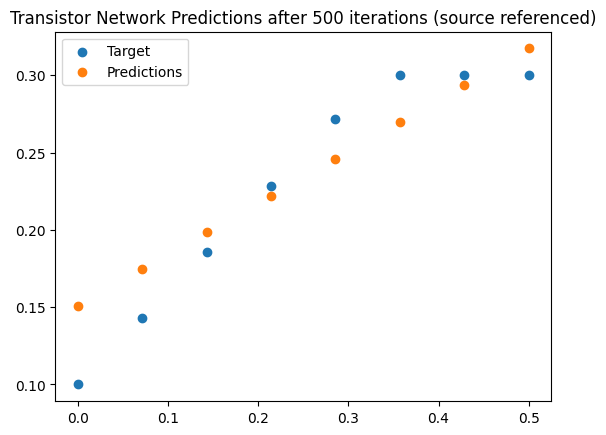

In [360]:
plt.scatter(train_inputs[:,-1], train_outputs[:,0], label='Target')
plt.scatter(train_inputs[:,-1], nonlinear_net.predict(train_inputs), label='Predictions')
plt.legend()
plt.title(f'Transistor Network Predictions after {5*epochs} iterations (source referenced)')

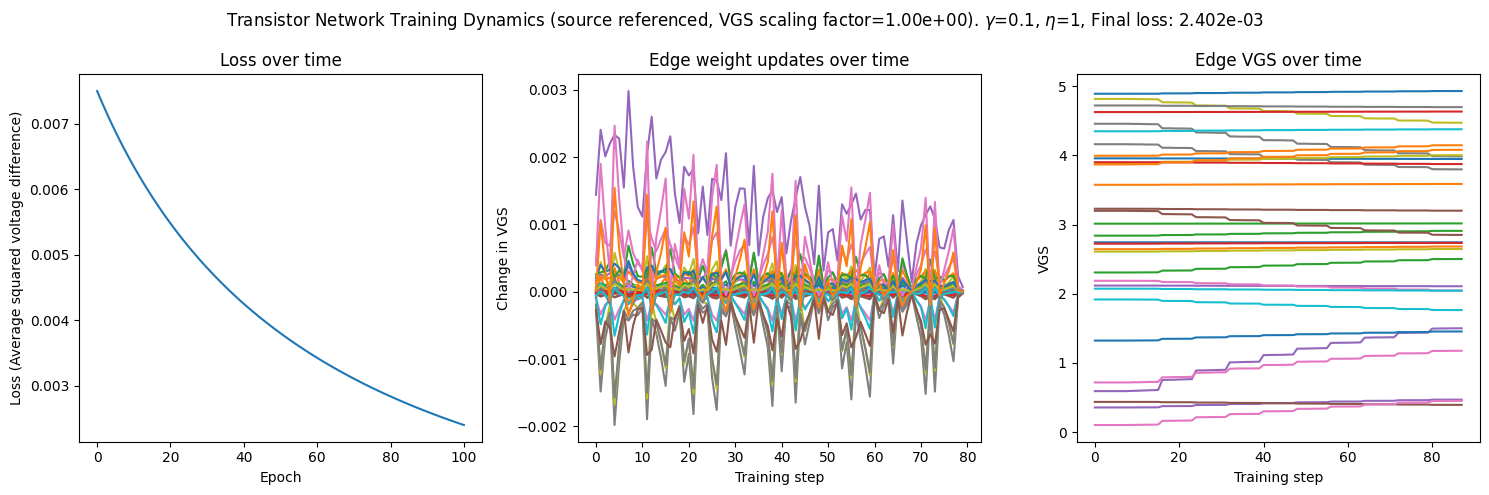

In [356]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle(f'Transistor Network Training Dynamics (source referenced, VGS scaling factor={transistor.edges[0].alpha:.2e}). $\gamma$={gamma}, $\eta$={eta}, Final loss: {loss[-1]:.3e}')

plt.subplot(1, 3, 1)
plt.plot(loss)
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss (Average squared voltage difference)')

plt.subplot(1, 3, 2)
plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.title('Edge weight updates over time')
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.xlabel('Training step')
plt.ylabel('Change in VGS')

plt.subplot(1, 3, 3)
plt.plot(weights.reshape(-1, weights.shape[-1]))
# plt.legend([f'Edge {i}' for i in range(weights.shape[-1])])
plt.title('Edge VGS over time')
plt.xlabel('Training step')
plt.ylabel('VGS')

plt.tight_layout()
plt.show()